<a href="https://colab.research.google.com/github/chicks2014/Hotel_booking_demand_analysis/blob/main/Hotel_booking_demand_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project setup**

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import time

# import basic ml libraries
import pandas as pd
import numpy as np
from collections import Counter

# import data prep libraries
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score, StratifiedKFold
import optuna
from optuna.integration import LightGBMPruningCallback
from sklearn.model_selection import StratifiedKFold

# import algo libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import lightgbm as lgbm
from keras.wrappers.scikit_learn import KerasClassifier

# import metrics libraries
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, auc, r2_score,mean_squared_error, classification_report
from sklearn.metrics import log_loss

#import ann libraries
import keras
from keras.layers import Dense
from keras.models import Sequential
import tensorflow as tf

# clusting libs
from sklearn.cluster import KMeans


#import visualization libraries
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")
%matplotlib inline

# pandas df display
pd.pandas.set_option('display.max_columns',None)

# warnings setting
import warnings
warnings.filterwarnings('ignore')

In [ ]:
os.getcwd()

'/content'

In [ ]:
os.chdir('/content/drive/MyDrive/Interviews/Egencia/')

# **Load Data to Dataframe and basic statistics**

In [ ]:
# load first 100k records only
data=pd.read_csv("train.csv", nrows=100000)

In [ ]:
df = data.copy()

In [ ]:
# df info to heck datatype and non-null count
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   date_time                  100000 non-null  object 
 1   site_name                  100000 non-null  int64  
 2   posa_continent             100000 non-null  int64  
 3   user_location_country      100000 non-null  int64  
 4   user_location_region       100000 non-null  int64  
 5   user_location_city         100000 non-null  int64  
 6   orig_destination_distance  63078 non-null   float64
 7   user_id                    100000 non-null  int64  
 8   is_mobile                  100000 non-null  int64  
 9   is_package                 100000 non-null  int64  
 10  channel                    100000 non-null  int64  
 11  srch_ci                    99929 non-null   object 
 12  srch_co                    99929 non-null   object 
 13  srch_adults_cnt            100

In [ ]:
#  df shape
df.shape

(100000, 24)

In [ ]:
# view sammple records
df.sample(5)

date_time  site_name  posa_continent  user_location_country  \
66948  2014-10-16 09:02:11          2               3                     66   
34208  2014-11-18 09:43:26          2               3                     66   
89336  2014-05-19 20:30:16         14               1                    214   
8008   2014-08-03 21:31:54          2               3                     66   
34098  2014-06-11 09:28:55          2               3                     66   

       user_location_region  user_location_city  orig_destination_distance  \
66948                   220               10986                  2583.3374   
34208                   294                7976                   960.1858   
89336                   118               20730                        NaN   
8008                    174               38801                        NaN   
34098                   220                2086                  5252.3841   

       user_id  is_mobile  is_package  channel     srch_ci     srch_co  \
66948   245492          0           1        9  2014-11-13  2014-11-16   
34208   134013          0           0        0  2014-12-27  2015-01-02   
89336   358172          1           1        9  2014-06-06  2014-06-09   
8008     47886          0           1        3  2014-09-22  2014-09-25   
34098   133805          0           0        0  2014-06-23  2014-06-24   

       srch_adults_cnt  srch_children_cnt  srch_rm_cnt  srch_destination_id  \
66948                1                  0            1                 8281   
34208                1                  0            1                12418   
89336                1                  0            1                  468   
8008                 3                  0            1                 8740   
34098                2                  1            1                50701   

       srch_destination_type_id  is_booking  cnt  hotel_continent  \
66948                         1           0    2                2   
34208                         5           1    1                2   
89336                         1           0    1                3   
8008                          1           0    1                6   
34098                         6           0    1                6   

       hotel_country  hotel_market  hotel_cluster  
66948             50           663             32  
34208             50           639             94  
89336             48           153              5  
8008             105            12             10  
34098              4           151             58

In [ ]:
# view all columns
df.columns

Index(['date_time', 'site_name', 'posa_continent', 'user_location_country',
       'user_location_region', 'user_location_city',
       'orig_destination_distance', 'user_id', 'is_mobile', 'is_package',
       'channel', 'srch_ci', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt',
       'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id',
       'is_booking', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market',
       'hotel_cluster'],
      dtype='object')

In [ ]:
#get categorical and numerical features
def get_cat_num_features(df):
  cat_cols = [col for col in df.columns if df[col].dtype=='object']
  print('Categorical features are: ', cat_cols, '\n')
  print('Total Categorical features : ', len(cat_cols), '\n')

  num_cols = [col for col in df.columns if df[col].dtype!='object' and col!='is_canceled']
  print('Numerical features are: ', num_cols, '\n')
  print('Total Numerical features : ', len(num_cols), '\n')
  return num_cols, cat_cols

In [ ]:
# get categorical and numeric features
num_cols, cat_cols = get_cat_num_features(df)

Categorical features are:  ['date_time', 'srch_ci', 'srch_co'] 

Total Categorical features :  3 

Numerical features are:  ['site_name', 'posa_continent', 'user_location_country', 'user_location_region', 'user_location_city', 'orig_destination_distance', 'user_id', 'is_mobile', 'is_package', 'channel', 'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id', 'is_booking', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market', 'hotel_cluster'] 

Total Numerical features :  21 



In [ ]:
#  describe dataframe stats
df.describe().T

count           mean            std      min  \
site_name                  100000.0       9.100140      12.090910   2.0000   
posa_continent             100000.0       2.637850       0.751001   0.0000   
user_location_country      100000.0      84.531040      54.320574   0.0000   
user_location_region       100000.0     311.630930     209.399151   0.0000   
user_location_city         100000.0   28465.223540   16822.922817   3.0000   
orig_destination_distance   63078.0    1897.609161    2123.885180   0.0056   
user_id                    100000.0  195700.878390  110173.879786  12.0000   
is_mobile                  100000.0       0.138030       0.344933   0.0000   
is_package                 100000.0       0.260470       0.438893   0.0000   
channel                    100000.0       5.760540       3.771156   0.0000   
srch_adults_cnt            100000.0       2.029830       0.889903   0.0000   
srch_children_cnt          100000.0       0.325160       0.722341   0.0000   
srch_rm_cnt                100000.0       1.112700       0.441928   0.0000   
srch_destination_id        100000.0   14511.034340   11043.082364   8.0000   
srch_destination_type_id   100000.0       2.590540       2.160456   1.0000   
is_booking                 100000.0       0.082700       0.275430   0.0000   
cnt                        100000.0       1.477770       1.197163   1.0000   
hotel_continent            100000.0       3.206530       1.624119   0.0000   
hotel_country              100000.0      80.972620      55.679861   0.0000   
hotel_market               100000.0     597.559610     507.624672   0.0000   
hotel_cluster              100000.0      49.745760      28.950630   0.0000   

                                     25%           50%          75%  \
site_name                       2.000000       2.00000      11.0000   
posa_continent                  3.000000       3.00000       3.0000   
user_location_country          66.000000      66.00000      69.0000   
user_location_region          174.000000     311.00000     385.0000   
user_location_city          13914.000000   27733.00000   43113.0000   
orig_destination_distance     290.528875    1093.88845    2518.1774   
user_id                    107548.000000  181983.00000  301357.0000   
is_mobile                       0.000000       0.00000       0.0000   
is_package                      0.000000       0.00000       1.0000   
channel                         2.000000       9.00000       9.0000   
srch_adults_cnt                 2.000000       2.00000       2.0000   
srch_children_cnt               0.000000       0.00000       0.0000   
srch_rm_cnt                     1.000000       1.00000       1.0000   
srch_destination_id          8267.000000   11271.00000   18881.0000   
srch_destination_type_id        1.000000       1.00000       5.0000   
is_booking                      0.000000       0.00000       0.0000   
cnt                             1.000000       1.00000       2.0000   
hotel_continent                 2.000000       2.00000       4.0000   
hotel_country                  50.000000      50.00000     106.0000   
hotel_market                  160.000000     585.00000     701.0000   
hotel_cluster                  25.000000      49.00000      73.0000   

                                   max  
site_name                      53.0000  
posa_continent                  4.0000  
user_location_country         239.0000  
user_location_region         1025.0000  
user_location_city          56495.0000  
orig_destination_distance   11641.2242  
user_id                    391007.0000  
is_mobile                       1.0000  
is_package                      1.0000  
channel                        10.0000  
srch_adults_cnt                 9.0000  
srch_children_cnt               9.0000  
srch_rm_cnt                     8.0000  
srch_destination_id         65035.0000  
srch_destination_type_id        9.0000  
is_booking                      1.0000  
cnt                            59.0000  
hotel_contin



> We have dataframe with 100k records and 24 features. From the above stats we can see that there are few columns has less counts which means there are missing values exists.




# **Data visualization**

In [ ]:
# plot categorical features
# need to pass dataframe and feature name
def plot_cat_features(DataFrame, feature):
    # Check the distribution of booking
    plt.figure(figsize=(15,7))

    #plot pie chart
    plt.subplot(1,2,1)
    label = DataFrame[feature].value_counts().index
    label_count = DataFrame[feature].value_counts().values

    plt.pie(data=DataFrame, x=label_count, labels=label, autopct='%1.1f%%', shadow=True, radius=1)

    #Target feature distribution with the given feature
    plt.subplot(1,2,2)
    sns.countplot(x='is_booking', data=DataFrame ,hue=feature)

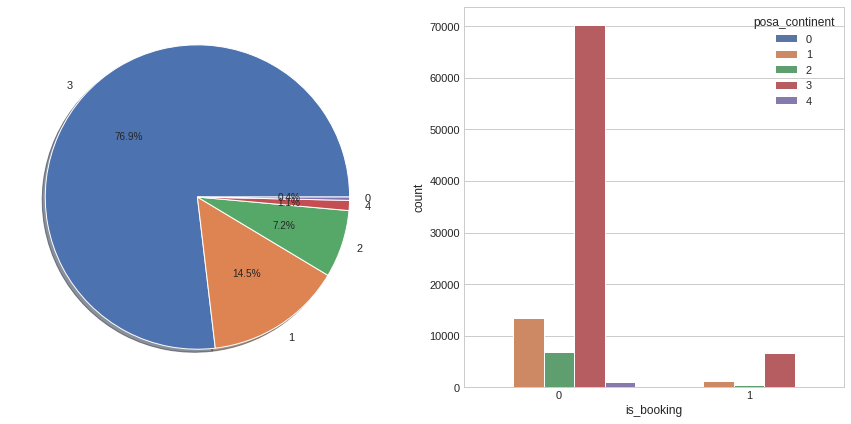

In [ ]:
plot_cat_features(df, 'posa_continent')

> From the above graph we can see that **posa_continent** 3 has higher counts in both clicks and bookings



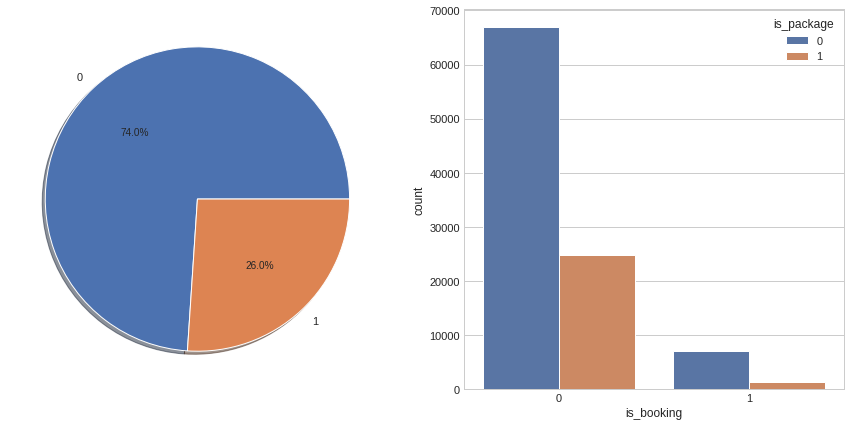

In [ ]:
plot_cat_features(df, 'is_package')



> We can say that most of our users are not as part of a package in both the case if it is bookings or just clicks



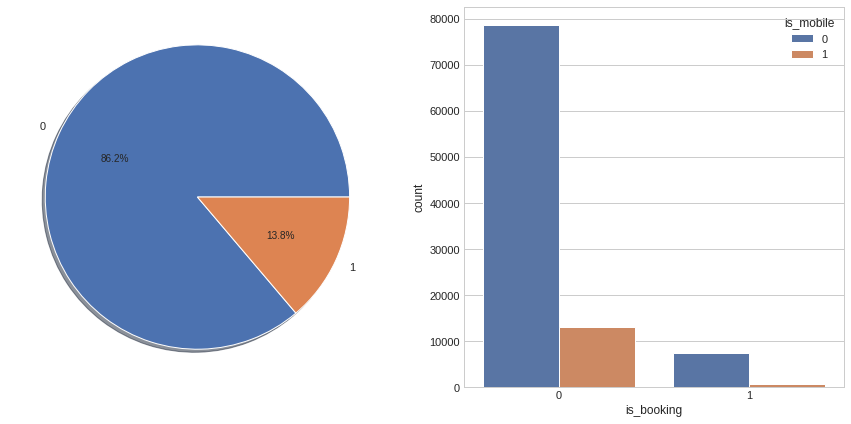

In [ ]:
plot_cat_features(df, 'is_mobile')



> From the above graph we can see that travellers don't like to generate booking from mobile device. They are more convenient to book from other then mobile devices like Tablet/Computer/Laptops



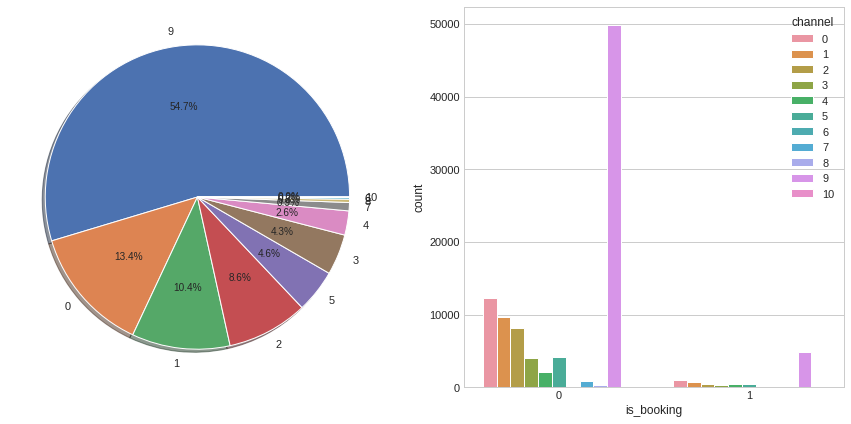

In [ ]:
plot_cat_features(df, 'channel')



> Most of bookings and clicks are getting generated by marketing channel number 9. We can sya that  marketing channel 9 is very active to attract users whether that leads convert to booking or just stay as clicks 



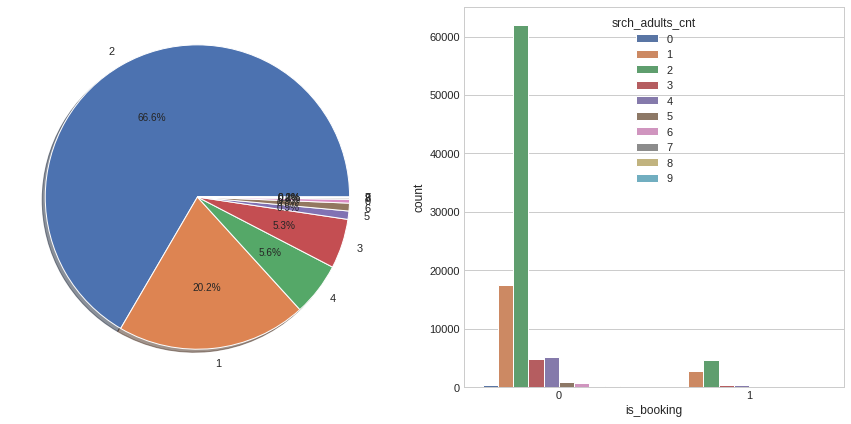

In [ ]:
plot_cat_features(df, 'srch_adults_cnt')



> From the above graph we can say that users are mostly searching for 2 adults only 



In [ ]:
# plot frequency counts
# params: dataframe, feature name, figure size in x, y if req. other than defaults 
def plot_count(df, feature, figsize_x = 10, figsize_y = 3):
  fig = plt.figure(figsize=(figsize_x, figsize_y))

  # What's the frequency of bookings through mobile?
  sns.countplot(x= feature,data=df.sort_values(by=[feature]))

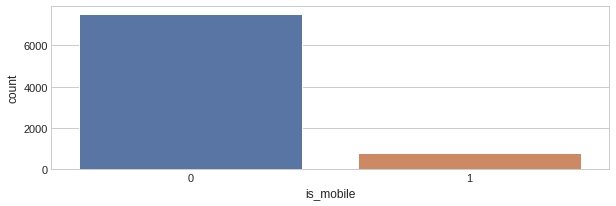

In [ ]:
bookings_df = df[df["is_booking"] == 1]
plot_count(bookings_df, 'is_mobile')



> Most of users are not using mobile as device on our platform/portal



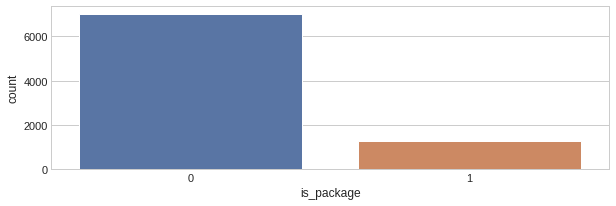

In [ ]:
plot_count(bookings_df, 'is_package')

> Users are doing booking or clicks as paer of a package

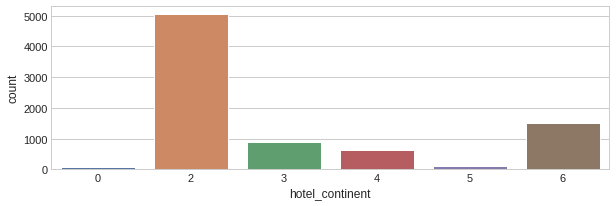

In [ ]:
plot_count(bookings_df, 'hotel_continent')

> Hotel continent 2 has higher users. It must be at some famous location

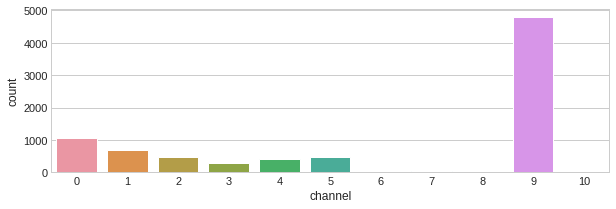

In [ ]:
plot_count(bookings_df, 'channel')

> Marketing channel 9 is most active channel to get users

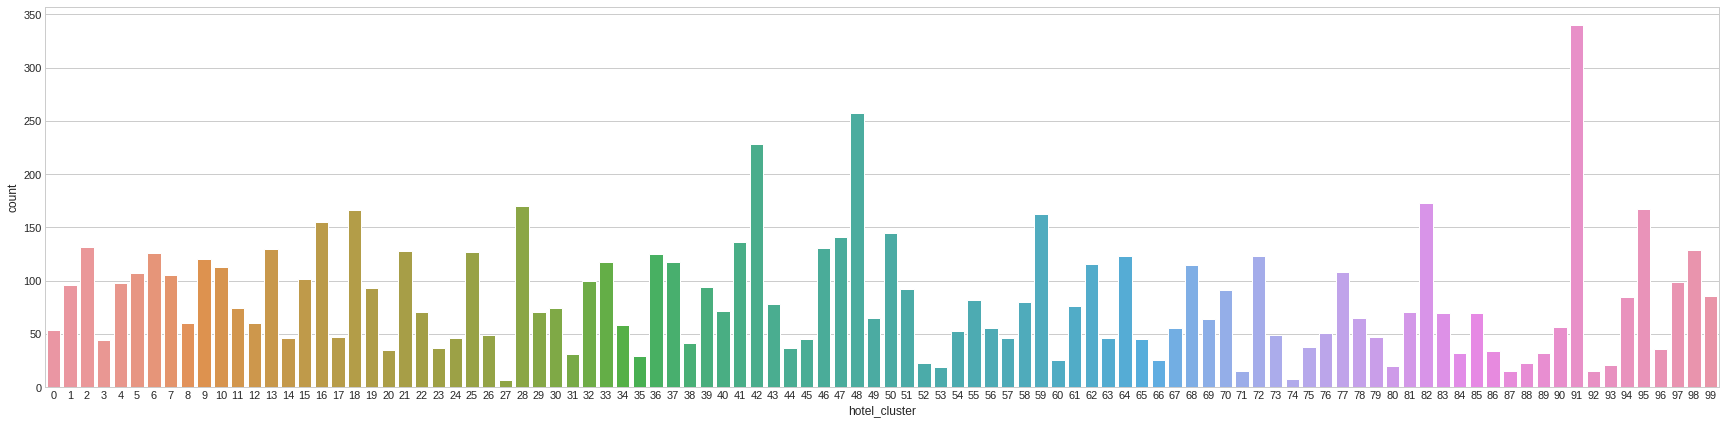

In [ ]:
plot_count(bookings_df, 'hotel_cluster', figsize_x = 30, figsize_y = 7)

> We can see that, most dense hotels (hotel counts > 200) are are in cluster no 42, 48 and 91. While less dense clusters are 27, 74, 71, 87, 92 etc. which has less than 50 counts 

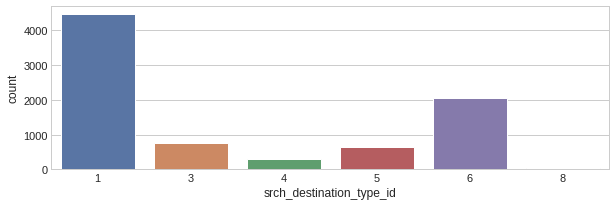

In [ ]:
plot_count(bookings_df, 'srch_destination_type_id')

> Popular destination among the users are 1 and 6 where the hotel search was performed by users

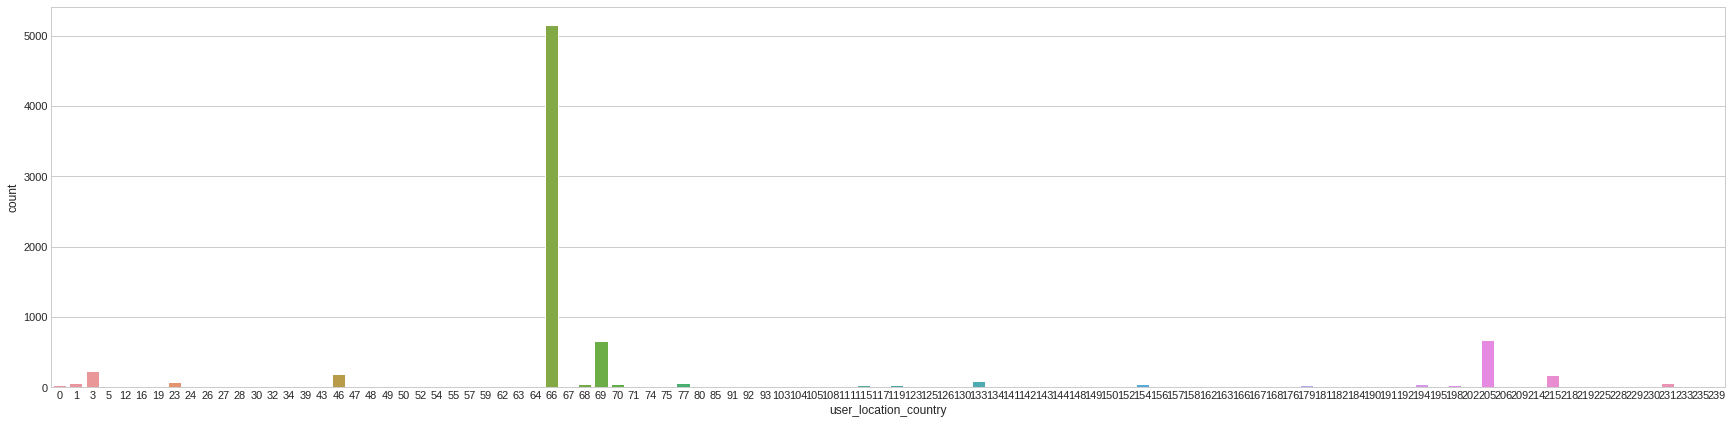

In [ ]:
plot_count(bookings_df, 'user_location_country', figsize_x = 30, figsize_y = 7)

> Our most of users are from country id 66. 

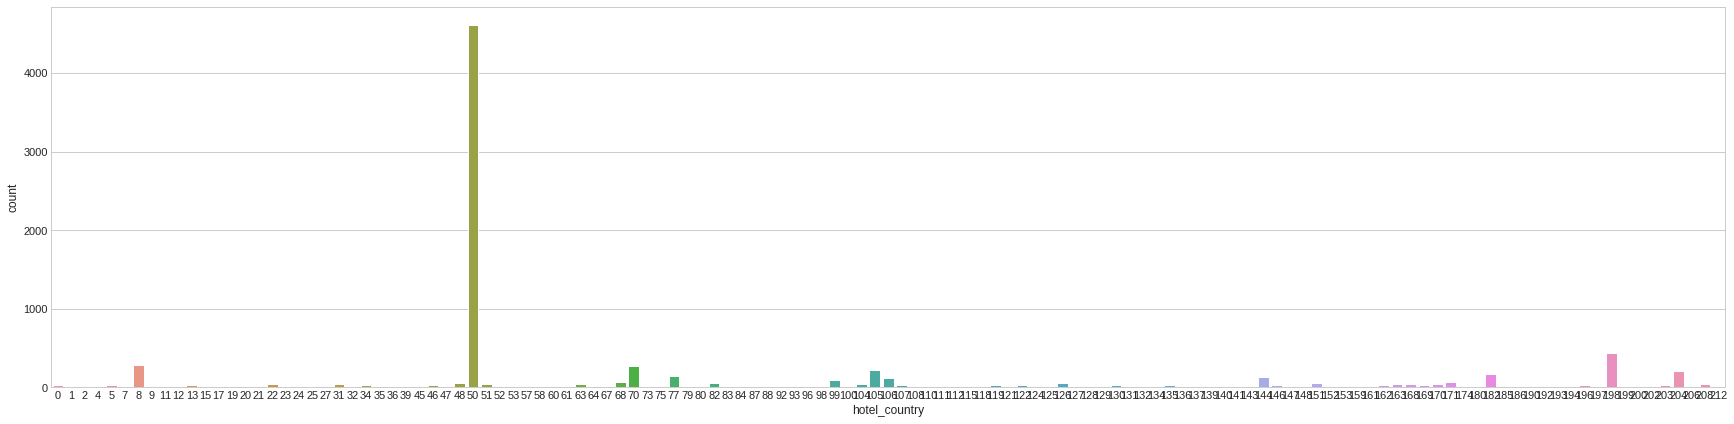

In [ ]:
plot_count(bookings_df, 'hotel_country', figsize_x = 30, figsize_y = 7)



> We can say that majority of hotels are in country Id 50



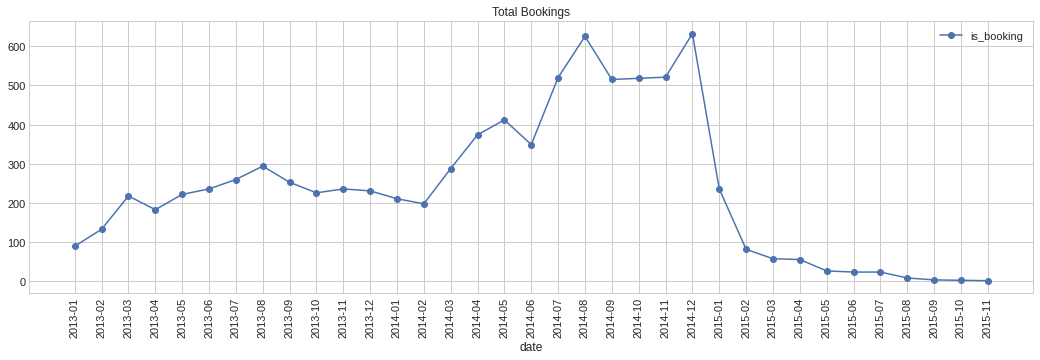

In [ ]:
# booking trends

bookings_df['date']  = bookings_df['srch_ci'].apply(lambda x: (str(x)[:7]) if x == x else np.nan)

# Plot number of bookings over Date
date_bookings  = bookings_df.groupby('date')["is_booking"].sum()
ax1 = date_bookings.plot(legend=True, marker='o',title="Total Bookings", figsize=(18,5)) 
ax1.set_xticks(range(len(date_bookings)))
xlabels = ax1.set_xticklabels(date_bookings.index.tolist(), rotation=90)



> We can see that majority of bookings are performed in Auguest-2014 to December-2014



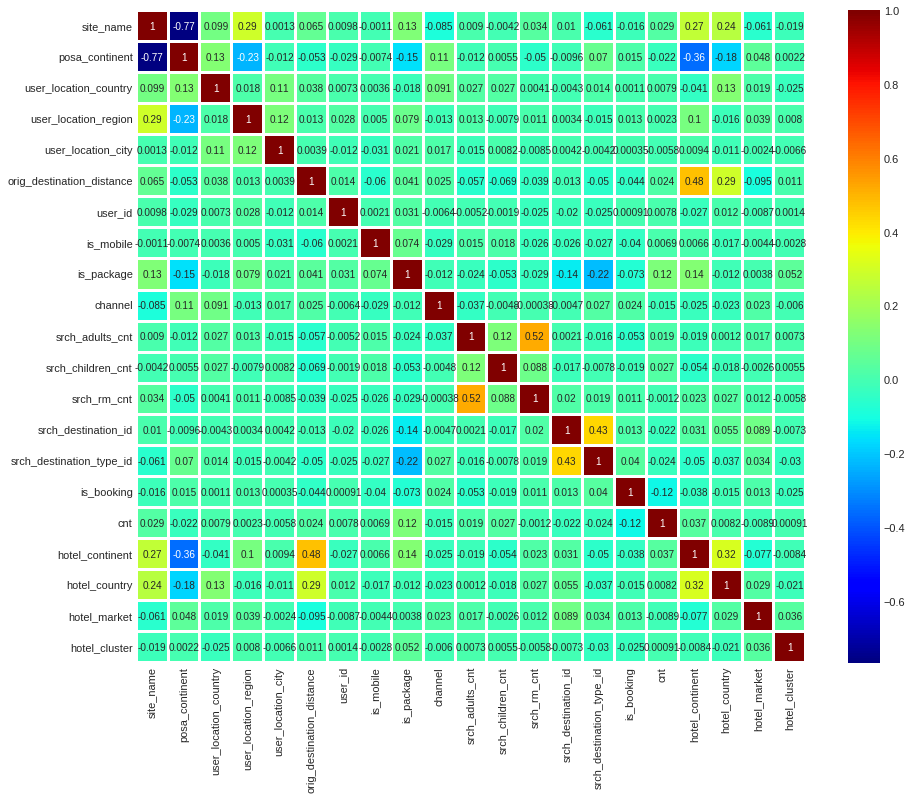

In [ ]:
# find correlation between features

fig, ax = plt.subplots()
fig.set_size_inches(15, 12)
sns.heatmap(df.corr(), cmap='jet',ax=ax, annot=True, linewidths=2)

> This is features correlation graph. From this heatmap graph we can see correlation between different features.

- This correlation values can be in between **-1 to +1**
- If correlation > 0.7 we can say that they are **highly positive** co-related with each others which means if one feature value will increase then other feature value will also increase by correlation factor times
- If correlation < -0.7 we can say that they are **highly negative** co-related with each others which means if one feature value will decrease then other feature value will also decrease by correlation factor times



---

- orig_destination_distance and hotel_continent are corelated by value 0.48
- srch_adults_cnt and srch_rm_cnt are corelated by value 0.52 This is obivious reason if more adults will required more rooms

# **EDA**

> Missing value

In [ ]:
# calculate missing value counts and percentange
#  param: dataframe
def calc_missing_value(df):
  total = df.isnull().sum().sort_values(ascending=False)
  percent = ((df.isnull().sum()/len(df.index)) * 100 ).sort_values(ascending=False)
  missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
  return missing_data

In [ ]:
missing_data = calc_missing_value(df)
# display top 10 features with missing values
missing_data.head(10)

Total  Percent
orig_destination_distance  36922   36.922
srch_co                       71    0.071
srch_ci                       71    0.071
srch_adults_cnt                0    0.000
hotel_market                   0    0.000
hotel_country                  0    0.000
hotel_continent                0    0.000
cnt                            0    0.000
is_booking                     0    0.000
srch_destination_type_id       0    0.000

In [ ]:
# here let's fill missing values with forward fill
df.fillna(method="ffill", inplace=True)

In [ ]:
# post filling out missing values, we should not have any missing values in ou dataframe
#  to verify let's call again same function

missing_data = calc_missing_value(df)
missing_data.head(10)

Total  Percent
date_time                     0      0.0
site_name                     0      0.0
hotel_market                  0      0.0
hotel_country                 0      0.0
hotel_continent               0      0.0
cnt                           0      0.0
is_booking                    0      0.0
srch_destination_type_id      0      0.0
srch_destination_id           0      0.0
srch_rm_cnt                   0      0.0


> View Outliers in our dataframe



In [ ]:
# display outlier function
#  param : feature name
def display_ourliers(cols):
  n = 1
  plt.figure(figsize=(20,15))

  for column in cols:
    plt.subplot(5,5,n)
    n = n+1
    sns.boxplot(df[column])
    plt.tight_layout()

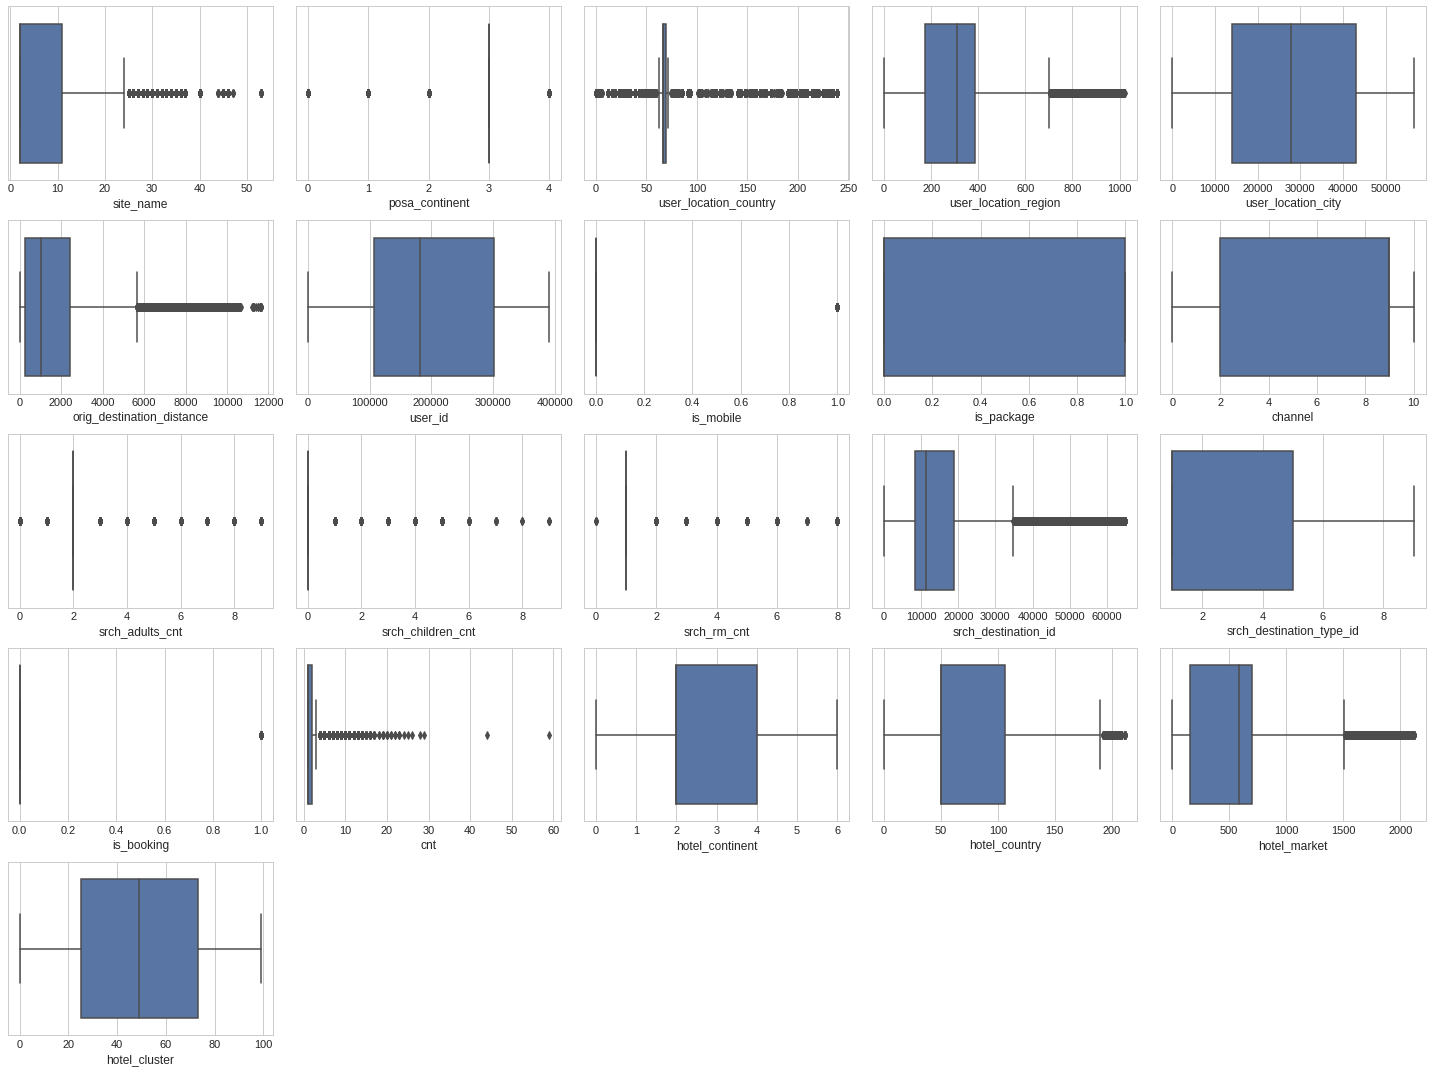

In [ ]:
display_ourliers(num_cols)



>Feature Engineering


---

- Let's add some new features using search datetime, checkin date and check out dates


In [ ]:
def get_days_from_date(df):
    df['date_time'] = pd.to_datetime(df['date_time'])
    df['srch_ci'] = pd.to_datetime(df['srch_ci'])
    df['srch_co'] = pd.to_datetime(df['srch_co'])
    
    df['stay_days'] = (df['srch_co'] - df['srch_ci']).astype('timedelta64[D]')
    df['days_btw_booking_ci'] = (df['srch_ci'] - df['date_time']).astype('timedelta64[D]')
    
    # For hotel check-in
    # Month, Year, Day
    df['cin_day'] = df["srch_ci"].apply(lambda x: x.day).astype('int64')
    df['cin_month'] = df["srch_ci"].apply(lambda x: x.month).astype('int64')
    df['cin_year'] = df["srch_ci"].apply(lambda x: x.year).astype('int64')

In [ ]:
get_days_from_date(df)

In [ ]:
df.sample(5)

date_time  site_name  posa_continent  user_location_country  \
36153 2014-12-02 20:59:41          2               3                     66   
52069 2013-07-15 19:31:02         11               3                    205   
94270 2014-07-30 13:12:19          2               3                     66   
75090 2014-07-11 05:10:29          2               3                     66   
71192 2014-12-12 19:04:01          2               3                     66   

       user_location_region  user_location_city  orig_destination_distance  \
36153                   153               50542                   109.0561   
52069                   354                2875                   181.8474   
94270                   462               38773                  1118.9671   
75090                   293               26303                  1527.5637   
71192                   174               52320                  2421.2228   

       user_id  is_mobile  is_package  channel    srch_ci    srch_co  \
36153   140072          0           0        1 2014-12-30 2015-01-03   
52069   187659          0           0        0 2013-07-17 2013-07-19   
94270   370279          0           0        1 2014-08-01 2014-08-03   
75090   301357          0           0        9 2014-07-21 2014-07-22   
71192   275231          0           0        9 2015-04-10 2015-04-18   

       srch_adults_cnt  srch_children_cnt  srch_rm_cnt  srch_destination_id  \
36153                2                  0            1                23693   
52069                2                  1            1                14838   
94270                6                  4            3                 1630   
75090                1                  0            1                 8272   
71192                2                  0            1                12654   

       srch_destination_type_id  is_booking  cnt  hotel_continent  \
36153                         1           0    1                2   
52069                         1           0    1                2   
94270                         1           1    1                4   
75090                         1           0    2                2   
71192                         5           0    1                2   

       hotel_country  hotel_market  hotel_cluster  stay_days  \
36153             50          1634             69        4.0   
52069             50           574             32        2.0   
94270              8          1402             48        2.0   
75090             50           659             91        1.0   
71192             50           682             42        8.0   

       days_btw_booking_ci  cin_day  cin_month  cin_year  
36153                 27.0       30         12      2014  
52069                  1.0       17          7      2013  
94270                  1.0        1          8      2014  
75090                  9.0       21          7      2014  
71192                118.0       10          4      2015

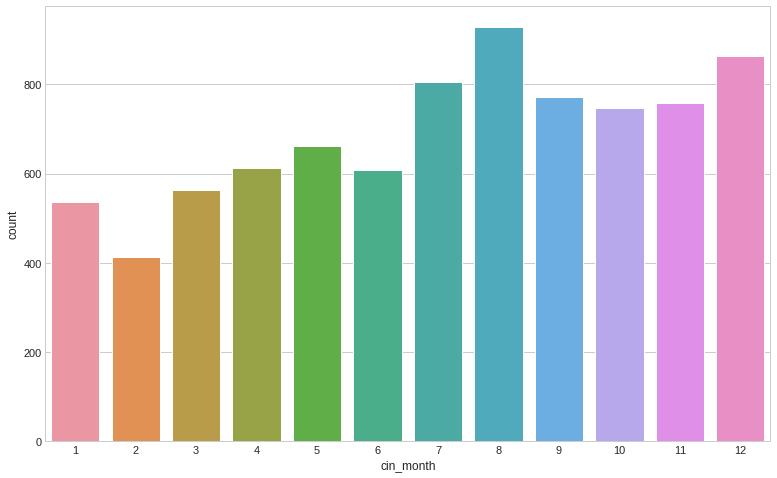

In [ ]:
bookings_df = df[df["is_booking"] == 1]
plot_count(bookings_df, 'cin_month', figsize_x=13, figsize_y=8)

> From the above graph we say that most of users did checking in auguest and december month. This is might be due to holiday or vacation time

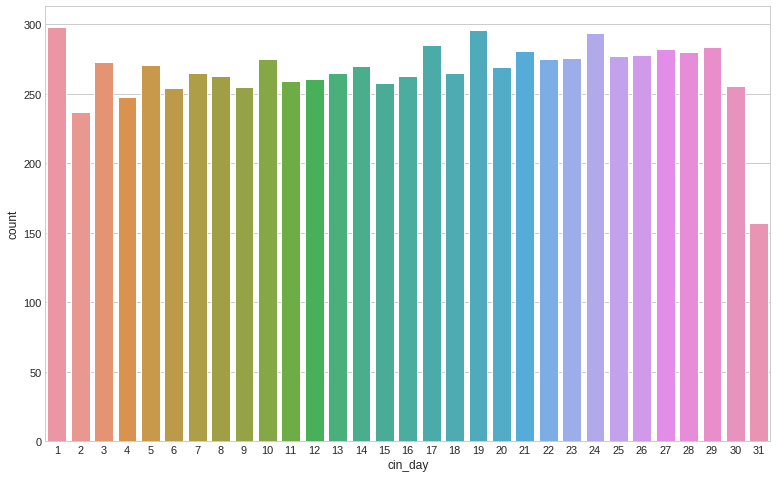

In [ ]:
plot_count(bookings_df, 'cin_day', figsize_x=13, figsize_y=8)

> checkin date is random. It seems users don't like to checkin on 31st

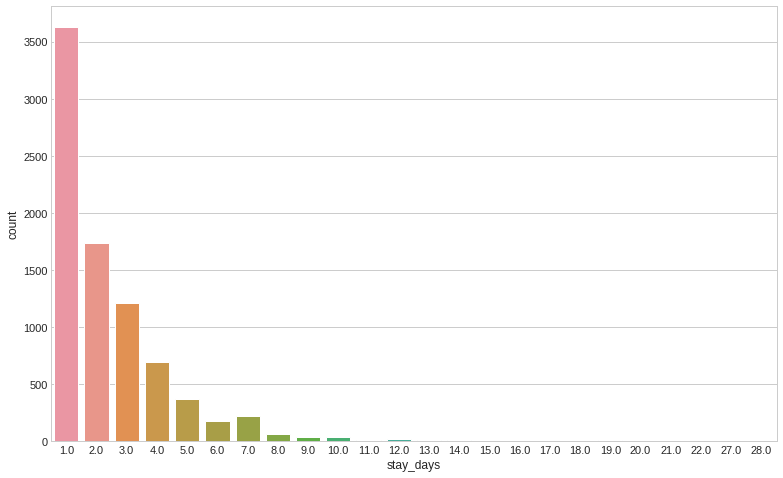

In [ ]:
plot_count(bookings_df, 'stay_days', figsize_x=13, figsize_y=8)



> Most of users are staying on hotels for 1 day only.



In [ ]:
# find out most popular search destinations group by hotel clusters

train = pd.read_csv('train.csv', dtype={'is_booking':bool,'srch_destination_id':np.int32, 'hotel_cluster':np.int32}, usecols=['srch_destination_id','is_booking','hotel_cluster'], chunksize=1000000)
aggs = []
print('-'*60)
print('group by in progress .', end='')
for chunk in train:
    agg = chunk.groupby(['srch_destination_id',
                         'hotel_cluster'])['is_booking'].agg(['sum','count'])
    agg.reset_index(inplace=True)
    aggs.append(agg)
    print('.',end='')
print('\ngroup by finished\n','-'*60)
aggs = pd.concat(aggs, axis=0)
# aggs.head()


CLICK_WEIGHT = 0.05
agg = aggs.groupby(['srch_destination_id','hotel_cluster']).sum().reset_index()
agg['count'] -= agg['sum']
agg = agg.rename(columns={'sum':'bookings','count':'clicks'})
agg['relevance'] = agg['bookings'] + CLICK_WEIGHT * agg['clicks']
# agg.head()

# # Define a function to get most popular hotels for a destination group.
def most_popular(group, n_max=5):
    relevance = group['relevance'].values
    hotel_cluster = group['hotel_cluster'].values
    most_popular = hotel_cluster[np.argsort(relevance)[::-1]][:n_max]
    return np.array_str(most_popular)[1:-1] # remove square brackets

# Get most popular hotel clusters for all destinations.
most_pop = agg.groupby(['srch_destination_id']).apply(most_popular)
most_pop = pd.DataFrame(most_pop).rename(columns={0:'hotel_cluster'})
most_pop.head()

------------------------------------------------------------
group by in progress .......................................
group by finished
 ------------------------------------------------------------


hotel_cluster
srch_destination_id                
0                                 3
1                       20 30 60 57
2                    20 30 53 46 41
3                             53 60
4                    82 25 32 58 78

> most popular local hotel's are in cluster with destination

- search destination id 0 has cluster 3


# **Model Training**

**Training data preparation**

In [ ]:
# Let's do model training now
# define dependent and independent variables
# is_booking is our dependent variable. We'll buid a model that can predict bookings based on input data
y = df['is_booking']

# need to drop dates columns
X = df.drop(['date_time','srch_ci','srch_co','is_booking'], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 25 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   site_name                  100000 non-null  int64  
 1   posa_continent             100000 non-null  int64  
 2   user_location_country      100000 non-null  int64  
 3   user_location_region       100000 non-null  int64  
 4   user_location_city         100000 non-null  int64  
 5   orig_destination_distance  100000 non-null  float64
 6   user_id                    100000 non-null  int64  
 7   is_mobile                  100000 non-null  int64  
 8   is_package                 100000 non-null  int64  
 9   channel                    100000 non-null  int64  
 10  srch_adults_cnt            100000 non-null  int64  
 11  srch_children_cnt          100000 non-null  int64  
 12  srch_rm_cnt                100000 non-null  int64  
 13  srch_destination_id        100

In [ ]:
# let's divide data to train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=584)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(70000, 25) (70000,)
(30000, 25) (30000,)


In [ ]:
# plot confusion matrix 
# param: confusion matrix
def plot_confusion_matrix(cm):
  cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

  sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
# function for print claissification matrix
def print_model_evaluation_matrix(y_test, y_pred):
  # accuracy
  acc = accuracy_score(y_test,y_pred)

  print('--'*50, '\n')
  print("Accuracy:" ,acc)

  cm = confusion_matrix(y_test, y_pred)
  print('Confusion matrix: \n\n', cm)
  print('\nTrue Positives(TP) = ', cm[0,0])
  print('\nTrue Negatives(TN) = ', cm[1,1])
  print('\nFalse Positives(FP) = ', cm[0,1])
  print('\nFalse Negatives(FN) = ', cm[1,0])
  plot_confusion_matrix(cm)

  print('--'*50, '\n')
  print("Classification Report: \n")
  print(classification_report(y_test, y_pred))


**Compare different Algo with kfold 5**

In [ ]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=5)

In [ ]:
# Modeling step Test differents algorithms 
def compare_algo_accuracy(X_train,y_train, kfold):
  random_state = 2
  classifiers = []
  classifiers.append(DecisionTreeClassifier(random_state=random_state))
  classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
  classifiers.append(RandomForestClassifier(random_state=random_state))
  classifiers.append(GradientBoostingClassifier(random_state=random_state))
  classifiers.append(LogisticRegression(random_state = random_state))

  cv_results = []
  for classifier in classifiers :
      cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

  cv_means = []
  cv_std = []
  for cv_result in cv_results:
      cv_means.append(cv_result.mean())
      cv_std.append(cv_result.std())

  algo = ["DecisionTree","AdaBoost", "RandomForest","GradientBoosting","LogisticRegression"]
  
  cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValErrors": cv_std,"Algorithm": algo})

  g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
  g.set_xlabel("Mean Accuracy")
  g = g.set_title("Cross validation scores")
  return cv_res

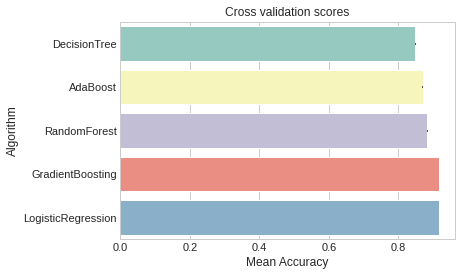

In [ ]:
cv_res = compare_algo_accuracy(X_train, y_train, kfold)

In [ ]:
# view cross val means and errors
cv_res

CrossValMeans  CrossValErrors           Algorithm
0       0.848829    1.682200e-03        DecisionTree
1       0.869514    2.326599e-03            AdaBoost
2       0.883729    9.911856e-04        RandomForest
3       0.916957    8.571429e-05    GradientBoosting
4       0.917071    1.110223e-16  LogisticRegression

> From the above stats we can say that Logistic Regression and Gradient Bossting has highest accuracy.



---



**Train Random-Forest Classifier**

- First let's do hyper-param tunning for RandomForest classiier

In [ ]:
# uncomment this code to find best params for random forest
# clf = RandomForestClassifier()

# grid_param = {
#     "n_estimators" : list(range(90, 130, 10)),
#     'min_samples_leaf' : list(range(1,6)),
#     'min_samples_split': list(range(4,9))
# }

# clf = GridSearchCV(clf, grid_param, cv = 5, scoring='accuracy')

# clf.fit(X_train, y_train)

# print(clf.best_params_)
# print(clf.best_score_)

In [ ]:
# train random forest model
def train_rf_model():
  # define model with params
  clf = RandomForestClassifier(n_estimators = 90, criterion = 'gini', min_samples_leaf = 5, min_samples_split = 8)

  # fit the params
  clf.fit(X_train, y_train)

  # predict
  y_pred=clf.predict(X_test)

  # print accruacy and confusion matrix 
  print_model_evaluation_matrix(y_test, y_pred)

  #  Features importance plot to check which features are important
  print("Features importance:")
  df_feature_imp = pd.DataFrame(data = clf.feature_importances_, columns = ['importance'], index = list(X_train.columns))
  fig = px.bar(df_feature_imp, x=df_feature_imp.index, y='importance', hover_data=['importance'], color='importance', labels={'pop':'importance of feature'}, height=400)
  fig.show()

---------------------------------------------------------------------------------------------------- 

Accuracy: 0.9156
Confusion matrix: 

 [[27463    72]
 [ 2460     5]]

True Positives(TP) =  27463

True Negatives(TN) =  5

False Positives(FP) =  72

False Negatives(FN) =  2460
---------------------------------------------------------------------------------------------------- 

Classification Report: 

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     27535
           1       0.06      0.00      0.00      2465

    accuracy                           0.92     30000
   macro avg       0.49      0.50      0.48     30000
weighted avg       0.85      0.92      0.88     30000

Features importance:


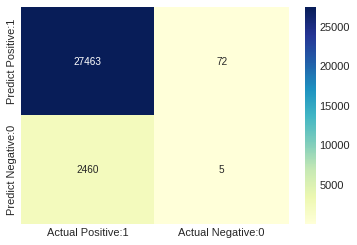

In [ ]:
train_rf_model()

> From the above graph we can see many features are less important, let's drop it

In [ ]:
# from the above graph we can see many features are less important, let's drop it
X_train = X_train.drop(['site_name', 'posa_continent', 'is_mobile','is_package', 'srch_children_cnt','srch_rm_cnt'], axis=1)
X_test = X_test.drop(['site_name', 'posa_continent', 'is_mobile','is_package', 'srch_children_cnt','srch_rm_cnt'], axis=1)



---



**Train LightGBM model**

- Here we'll use **optuna** library for Automated search for optimal hyperparameters using Python conditionals, loops, and syntax. 
- It is Efficiently search large spaces and prune unpromising trials for faster results
- We can optimize LightGBM hyperparameters, such as boosting type and the number of leaves, in three steps:



1.  Wrap model training with an objective function and return accuracy
2.  Suggest hyperparameters using a trial object
3.  Create a study object and execute the optimization





In [ ]:
# first let's do hyperparam tunning
def objective(trial, X, y):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = lgbm.LGBMClassifier(objective="binary", **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="binary_logloss",
            early_stopping_rounds=100,
            callbacks=[
                LightGBMPruningCallback(trial, "binary_logloss")
            ],  # Add a pruning callback
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)


In [ ]:
# create a strudy for trials to find best params
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X, y)

study.optimize(func, n_trials=20)

[I 2022-08-17 12:08:30,970] A new study created in memory with name: LGBM Classifier


[1]	valid_0's binary_logloss: 0.279869	valid_0's binary_logloss: 0.279869
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.278632	valid_0's binary_logloss: 0.278632
[3]	valid_0's binary_logloss: 0.276812	valid_0's binary_logloss: 0.276812
[4]	valid_0's binary_logloss: 0.273503	valid_0's binary_logloss: 0.273503
[5]	valid_0's binary_logloss: 0.272586	valid_0's binary_logloss: 0.272586
[6]	valid_0's binary_logloss: 0.269418	valid_0's binary_logloss: 0.269418
[7]	valid_0's binary_logloss: 0.267248	valid_0's binary_logloss: 0.267248
[8]	valid_0's binary_logloss: 0.265012	valid_0's binary_logloss: 0.265012
[9]	valid_0's binary_logloss: 0.263172	valid_0's binary_logloss: 0.263172
[10]	valid_0's binary_logloss: 0.261533	valid_0's binary_logloss: 0.261533
[11]	valid_0's binary_logloss: 0.26104	valid_0's binary_logloss: 0.26104
[12]	valid_0's binary_logloss: 0.259817	valid_0's binary_logloss: 0.259817
[13]	valid_0's binary_logloss: 0.259436	valid_0'

[I 2022-08-17 12:08:38,761] Trial 0 finished with value: 0.25278469734429654 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14098175499532875, 'num_leaves': 2000, 'max_depth': 11, 'min_data_in_leaf': 5100, 'lambda_l1': 90, 'lambda_l2': 30, 'min_gain_to_split': 4.52915708981914, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 0 with value: 0.25278469734429654.


[1]	valid_0's binary_logloss: 0.284872	valid_0's binary_logloss: 0.284872
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.284872	valid_0's binary_logloss: 0.284872
[3]	valid_0's binary_logloss: 0.282062	valid_0's binary_logloss: 0.282062
[4]	valid_0's binary_logloss: 0.282062	valid_0's binary_logloss: 0.282062
[5]	valid_0's binary_logloss: 0.280651	valid_0's binary_logloss: 0.280651
[6]	valid_0's binary_logloss: 0.279627	valid_0's binary_logloss: 0.279627
[7]	valid_0's binary_logloss: 0.279627	valid_0's binary_logloss: 0.279627
[8]	valid_0's binary_logloss: 0.279303	valid_0's binary_logloss: 0.279303
[9]	valid_0's binary_logloss: 0.277082	valid_0's binary_logloss: 0.277082
[10]	valid_0's binary_logloss: 0.27688	valid_0's binary_logloss: 0.27688
[11]	valid_0's binary_logloss: 0.27688	valid_0's binary_logloss: 0.27688
[12]	valid_0's binary_logloss: 0.27688	valid_0's binary_logloss: 0.27688
[13]	valid_0's binary_logloss: 0.276038	valid_0's bi

[I 2022-08-17 12:08:45,338] Trial 1 finished with value: 0.2612885970769284 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16587910989392743, 'num_leaves': 1040, 'max_depth': 9, 'min_data_in_leaf': 3600, 'lambda_l1': 60, 'lambda_l2': 75, 'min_gain_to_split': 10.182984059135261, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 0 with value: 0.25278469734429654.


[1]	valid_0's binary_logloss: 0.283641	valid_0's binary_logloss: 0.283641
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.28334	valid_0's binary_logloss: 0.28334
[3]	valid_0's binary_logloss: 0.282672	valid_0's binary_logloss: 0.282672
[4]	valid_0's binary_logloss: 0.281437	valid_0's binary_logloss: 0.281437
[5]	valid_0's binary_logloss: 0.280936	valid_0's binary_logloss: 0.280936
[6]	valid_0's binary_logloss: 0.279637	valid_0's binary_logloss: 0.279637
[7]	valid_0's binary_logloss: 0.279549	valid_0's binary_logloss: 0.279549
[8]	valid_0's binary_logloss: 0.278228	valid_0's binary_logloss: 0.278228
[9]	valid_0's binary_logloss: 0.276958	valid_0's binary_logloss: 0.276958
[10]	valid_0's binary_logloss: 0.275828	valid_0's binary_logloss: 0.275828
[11]	valid_0's binary_logloss: 0.275544	valid_0's binary_logloss: 0.275544
[12]	valid_0's binary_logloss: 0.274414	valid_0's binary_logloss: 0.274414
[13]	valid_0's binary_logloss: 0.274003	valid_0'

[I 2022-08-17 12:08:52,199] Trial 2 finished with value: 0.2612291931074281 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05937700418293481, 'num_leaves': 1740, 'max_depth': 9, 'min_data_in_leaf': 1200, 'lambda_l1': 70, 'lambda_l2': 40, 'min_gain_to_split': 10.70460257516994, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 0 with value: 0.25278469734429654.


[154]	valid_0's binary_logloss: 0.261084	valid_0's binary_logloss: 0.261084
[155]	valid_0's binary_logloss: 0.261084	valid_0's binary_logloss: 0.261084
[156]	valid_0's binary_logloss: 0.261084	valid_0's binary_logloss: 0.261084
[157]	valid_0's binary_logloss: 0.261084	valid_0's binary_logloss: 0.261084
[158]	valid_0's binary_logloss: 0.261084	valid_0's binary_logloss: 0.261084
[159]	valid_0's binary_logloss: 0.261084	valid_0's binary_logloss: 0.261084
[160]	valid_0's binary_logloss: 0.261084	valid_0's binary_logloss: 0.261084
[161]	valid_0's binary_logloss: 0.261084	valid_0's binary_logloss: 0.261084
[162]	valid_0's binary_logloss: 0.261084	valid_0's binary_logloss: 0.261084
[163]	valid_0's binary_logloss: 0.261084	valid_0's binary_logloss: 0.261084
[164]	valid_0's binary_logloss: 0.261084	valid_0's binary_logloss: 0.261084
[165]	valid_0's binary_logloss: 0.261084	valid_0's binary_logloss: 0.261084
Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.261084	valid_0's bin

[I 2022-08-17 12:09:04,706] Trial 3 finished with value: 0.24936085114085235 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13933320709125632, 'num_leaves': 380, 'max_depth': 11, 'min_data_in_leaf': 4300, 'lambda_l1': 50, 'lambda_l2': 55, 'min_gain_to_split': 0.2907929237448015, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 3 with value: 0.24936085114085235.


[222]	valid_0's binary_logloss: 0.250259	valid_0's binary_logloss: 0.250259
[223]	valid_0's binary_logloss: 0.250259	valid_0's binary_logloss: 0.250259
[224]	valid_0's binary_logloss: 0.250259	valid_0's binary_logloss: 0.250259
[225]	valid_0's binary_logloss: 0.250259	valid_0's binary_logloss: 0.250259
[226]	valid_0's binary_logloss: 0.250259	valid_0's binary_logloss: 0.250259
[227]	valid_0's binary_logloss: 0.250259	valid_0's binary_logloss: 0.250259
[228]	valid_0's binary_logloss: 0.250259	valid_0's binary_logloss: 0.250259
[229]	valid_0's binary_logloss: 0.250259	valid_0's binary_logloss: 0.250259
Early stopping, best iteration is:
[129]	valid_0's binary_logloss: 0.250259	valid_0's binary_logloss: 0.250259
[1]	valid_0's binary_logloss: 0.284558	valid_0's binary_logloss: 0.284558
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.28416	valid_0's binary_logloss: 0.28416
[3]	valid_0's binary_logloss: 0.281132	valid_0's binary_logloss: 0.28113

[I 2022-08-17 12:09:15,218] Trial 4 finished with value: 0.25072723205658526 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11418745942158612, 'num_leaves': 2640, 'max_depth': 3, 'min_data_in_leaf': 800, 'lambda_l1': 50, 'lambda_l2': 30, 'min_gain_to_split': 11.15242109930418, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 3 with value: 0.24936085114085235.


[253]	valid_0's binary_logloss: 0.251338	valid_0's binary_logloss: 0.251338
Early stopping, best iteration is:
[153]	valid_0's binary_logloss: 0.251338	valid_0's binary_logloss: 0.251338


[I 2022-08-17 12:09:15,522] Trial 5 pruned. Trial was pruned at iteration 0.
[I 2022-08-17 12:09:15,806] Trial 6 pruned. Trial was pruned at iteration 0.


[1]	valid_0's binary_logloss: 0.277194	valid_0's binary_logloss: 0.277194
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.275534	valid_0's binary_logloss: 0.275534
[3]	valid_0's binary_logloss: 0.273621	valid_0's binary_logloss: 0.273621
[4]	valid_0's binary_logloss: 0.269815	valid_0's binary_logloss: 0.269815
[5]	valid_0's binary_logloss: 0.26859	valid_0's binary_logloss: 0.26859
[6]	valid_0's binary_logloss: 0.265425	valid_0's binary_logloss: 0.265425
[7]	valid_0's binary_logloss: 0.263229	valid_0's binary_logloss: 0.263229
[8]	valid_0's binary_logloss: 0.261224	valid_0's binary_logloss: 0.261224
[9]	valid_0's binary_logloss: 0.25964	valid_0's binary_logloss: 0.25964
[10]	valid_0's binary_logloss: 0.258559	valid_0's binary_logloss: 0.258559
[11]	valid_0's binary_logloss: 0.258277	valid_0's binary_logloss: 0.258277
[12]	valid_0's binary_logloss: 0.257237	valid_0's binary_logloss: 0.257237
[13]	valid_0's binary_logloss: 0.256997	valid_0's 

[I 2022-08-17 12:09:16,443] Trial 7 pruned. Trial was pruned at iteration 40.


[26]	valid_0's binary_logloss: 0.255694	valid_0's binary_logloss: 0.255694
[27]	valid_0's binary_logloss: 0.255694	valid_0's binary_logloss: 0.255694
[28]	valid_0's binary_logloss: 0.255694	valid_0's binary_logloss: 0.255694
[29]	valid_0's binary_logloss: 0.255694	valid_0's binary_logloss: 0.255694
[30]	valid_0's binary_logloss: 0.255694	valid_0's binary_logloss: 0.255694
[31]	valid_0's binary_logloss: 0.255694	valid_0's binary_logloss: 0.255694
[32]	valid_0's binary_logloss: 0.255694	valid_0's binary_logloss: 0.255694
[33]	valid_0's binary_logloss: 0.255694	valid_0's binary_logloss: 0.255694
[34]	valid_0's binary_logloss: 0.255694	valid_0's binary_logloss: 0.255694
[35]	valid_0's binary_logloss: 0.255694	valid_0's binary_logloss: 0.255694
[36]	valid_0's binary_logloss: 0.255694	valid_0's binary_logloss: 0.255694
[37]	valid_0's binary_logloss: 0.255694	valid_0's binary_logloss: 0.255694
[38]	valid_0's binary_logloss: 0.255694	valid_0's binary_logloss: 0.255694
[39]	valid_0's binary_log

[I 2022-08-17 12:09:16,790] Trial 8 pruned. Trial was pruned at iteration 0.


[1]	valid_0's binary_logloss: 0.279192	valid_0's binary_logloss: 0.279192
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.277674	valid_0's binary_logloss: 0.277674
[3]	valid_0's binary_logloss: 0.275704	valid_0's binary_logloss: 0.275704
[4]	valid_0's binary_logloss: 0.271986	valid_0's binary_logloss: 0.271986
[5]	valid_0's binary_logloss: 0.270765	valid_0's binary_logloss: 0.270765
[6]	valid_0's binary_logloss: 0.267522	valid_0's binary_logloss: 0.267522
[7]	valid_0's binary_logloss: 0.26527	valid_0's binary_logloss: 0.26527
[8]	valid_0's binary_logloss: 0.262965	valid_0's binary_logloss: 0.262965
[9]	valid_0's binary_logloss: 0.261084	valid_0's binary_logloss: 0.261084
[10]	valid_0's binary_logloss: 0.259284	valid_0's binary_logloss: 0.259284
[11]	valid_0's binary_logloss: 0.258808	valid_0's binary_logloss: 0.258808
[12]	valid_0's binary_logloss: 0.257403	valid_0's binary_logloss: 0.257403
[13]	valid_0's binary_logloss: 0.257046	valid_0'

[I 2022-08-17 12:09:25,455] Trial 9 finished with value: 0.25029980770492505 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14897409770815048, 'num_leaves': 2840, 'max_depth': 11, 'min_data_in_leaf': 4600, 'lambda_l1': 25, 'lambda_l2': 90, 'min_gain_to_split': 6.278255172723554, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 3 with value: 0.24936085114085235.



[142]	valid_0's binary_logloss: 0.250944	valid_0's binary_logloss: 0.250944
[143]	valid_0's binary_logloss: 0.250944	valid_0's binary_logloss: 0.250944
[144]	valid_0's binary_logloss: 0.250944	valid_0's binary_logloss: 0.250944
[145]	valid_0's binary_logloss: 0.250944	valid_0's binary_logloss: 0.250944
[146]	valid_0's binary_logloss: 0.250944	valid_0's binary_logloss: 0.250944
[147]	valid_0's binary_logloss: 0.250944	valid_0's binary_logloss: 0.250944
[148]	valid_0's binary_logloss: 0.250944	valid_0's binary_logloss: 0.250944
[149]	valid_0's binary_logloss: 0.250944	valid_0's binary_logloss: 0.250944
[150]	valid_0's binary_logloss: 0.250944	valid_0's binary_logloss: 0.250944
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.25094	valid_0's binary_logloss: 0.25094


[I 2022-08-17 12:09:25,783] Trial 10 pruned. Trial was pruned at iteration 0.
[I 2022-08-17 12:09:26,132] Trial 11 pruned. Trial was pruned at iteration 0.


[1]	valid_0's binary_logloss: 0.277802	valid_0's binary_logloss: 0.277802
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.27595	valid_0's binary_logloss: 0.27595
[3]	valid_0's binary_logloss: 0.27389	valid_0's binary_logloss: 0.27389
[4]	valid_0's binary_logloss: 0.269967	valid_0's binary_logloss: 0.269967
[5]	valid_0's binary_logloss: 0.268712	valid_0's binary_logloss: 0.268712
[6]	valid_0's binary_logloss: 0.265203	valid_0's binary_logloss: 0.265203
[7]	valid_0's binary_logloss: 0.262822	valid_0's binary_logloss: 0.262822
[8]	valid_0's binary_logloss: 0.26065	valid_0's binary_logloss: 0.26065
[9]	valid_0's binary_logloss: 0.25881	valid_0's binary_logloss: 0.25881
[10]	valid_0's binary_logloss: 0.257491	valid_0's binary_logloss: 0.257491
[11]	valid_0's binary_logloss: 0.257062	valid_0's binary_logloss: 0.257062
[12]	valid_0's binary_logloss: 0.255954	valid_0's binary_logloss: 0.255954
[13]	valid_0's binary_logloss: 0.255601	valid_0's bina

[I 2022-08-17 12:09:34,676] Trial 12 finished with value: 0.25062546112076567 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21245735843638253, 'num_leaves': 1160, 'max_depth': 12, 'min_data_in_leaf': 5300, 'lambda_l1': 20, 'lambda_l2': 100, 'min_gain_to_split': 3.5612274489884808, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 3 with value: 0.24936085114085235.


[144]	valid_0's binary_logloss: 0.251436	valid_0's binary_logloss: 0.251436
[145]	valid_0's binary_logloss: 0.251436	valid_0's binary_logloss: 0.251436
[146]	valid_0's binary_logloss: 0.251436	valid_0's binary_logloss: 0.251436
[147]	valid_0's binary_logloss: 0.251436	valid_0's binary_logloss: 0.251436
[148]	valid_0's binary_logloss: 0.251436	valid_0's binary_logloss: 0.251436
[149]	valid_0's binary_logloss: 0.251436	valid_0's binary_logloss: 0.251436
[150]	valid_0's binary_logloss: 0.251436	valid_0's binary_logloss: 0.251436
[151]	valid_0's binary_logloss: 0.251436	valid_0's binary_logloss: 0.251436
[152]	valid_0's binary_logloss: 0.251436	valid_0's binary_logloss: 0.251436
[153]	valid_0's binary_logloss: 0.251436	valid_0's binary_logloss: 0.251436
[154]	valid_0's binary_logloss: 0.251436	valid_0's binary_logloss: 0.251436
[155]	valid_0's binary_logloss: 0.251436	valid_0's binary_logloss: 0.251436
[156]	valid_0's binary_logloss: 0.251436	valid_0's binary_logloss: 0.251436
[157]	valid_

[I 2022-08-17 12:09:34,988] Trial 13 pruned. Trial was pruned at iteration 0.


[1]	valid_0's binary_logloss: 0.274273	valid_0's binary_logloss: 0.274273
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.270615	valid_0's binary_logloss: 0.270615
[3]	valid_0's binary_logloss: 0.264622	valid_0's binary_logloss: 0.264622
[4]	valid_0's binary_logloss: 0.260636	valid_0's binary_logloss: 0.260636
[5]	valid_0's binary_logloss: 0.259588	valid_0's binary_logloss: 0.259588
[6]	valid_0's binary_logloss: 0.256956	valid_0's binary_logloss: 0.256956
[7]	valid_0's binary_logloss: 0.254939	valid_0's binary_logloss: 0.254939
[8]	valid_0's binary_logloss: 0.253521	valid_0's binary_logloss: 0.253521
[9]	valid_0's binary_logloss: 0.252423	valid_0's binary_logloss: 0.252423
[10]	valid_0's binary_logloss: 0.251505	valid_0's binary_logloss: 0.251505
[11]	valid_0's binary_logloss: 0.250956	valid_0's binary_logloss: 0.250956
[12]	valid_0's binary_logloss: 0.250304	valid_0's binary_logloss: 0.250304
[13]	valid_0's binary_logloss: 0.249995	valid_

[I 2022-08-17 12:09:59,310] Trial 14 finished with value: 0.24650851484492065 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28909177587094936, 'num_leaves': 660, 'max_depth': 10, 'min_data_in_leaf': 5400, 'lambda_l1': 0, 'lambda_l2': 65, 'min_gain_to_split': 2.4563322572348625, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 14 with value: 0.24650851484492065.
[I 2022-08-17 12:09:59,621] Trial 15 pruned. Trial was pruned at iteration 0.
[I 2022-08-17 12:09:59,947] Trial 16 pruned. Trial was pruned at iteration 0.
[I 2022-08-17 12:10:00,265] Trial 17 pruned. Trial was pruned at iteration 0.


[1]	valid_0's binary_logloss: 0.276814	valid_0's binary_logloss: 0.276814
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.274978	valid_0's binary_logloss: 0.274978
[3]	valid_0's binary_logloss: 0.272486	valid_0's binary_logloss: 0.272486
[4]	valid_0's binary_logloss: 0.268081	valid_0's binary_logloss: 0.268081
[5]	valid_0's binary_logloss: 0.266594	valid_0's binary_logloss: 0.266594
[6]	valid_0's binary_logloss: 0.262827	valid_0's binary_logloss: 0.262827
[7]	valid_0's binary_logloss: 0.26231	valid_0's binary_logloss: 0.26231
[8]	valid_0's binary_logloss: 0.259555	valid_0's binary_logloss: 0.259555
[9]	valid_0's binary_logloss: 0.257547	valid_0's binary_logloss: 0.257547
[10]	valid_0's binary_logloss: 0.256119	valid_0's binary_logloss: 0.256119
[11]	valid_0's binary_logloss: 0.255592	valid_0's binary_logloss: 0.255592
[12]	valid_0's binary_logloss: 0.254445	valid_0's binary_logloss: 0.254445
[13]	valid_0's binary_logloss: 0.254152	valid_0'

[I 2022-08-17 12:10:03,351] Trial 18 pruned. Trial was pruned at iteration 270.


[248]	valid_0's binary_logloss: 0.245884	valid_0's binary_logloss: 0.245884
[249]	valid_0's binary_logloss: 0.245884	valid_0's binary_logloss: 0.245884
[250]	valid_0's binary_logloss: 0.245884	valid_0's binary_logloss: 0.245884
[251]	valid_0's binary_logloss: 0.245884	valid_0's binary_logloss: 0.245884
[252]	valid_0's binary_logloss: 0.245884	valid_0's binary_logloss: 0.245884
[253]	valid_0's binary_logloss: 0.245884	valid_0's binary_logloss: 0.245884
[254]	valid_0's binary_logloss: 0.245884	valid_0's binary_logloss: 0.245884
[255]	valid_0's binary_logloss: 0.245884	valid_0's binary_logloss: 0.245884
[256]	valid_0's binary_logloss: 0.245884	valid_0's binary_logloss: 0.245884
[257]	valid_0's binary_logloss: 0.245884	valid_0's binary_logloss: 0.245884
[258]	valid_0's binary_logloss: 0.245884	valid_0's binary_logloss: 0.245884
[259]	valid_0's binary_logloss: 0.245884	valid_0's binary_logloss: 0.245884
[260]	valid_0's binary_logloss: 0.245884	valid_0's binary_logloss: 0.245884
[261]	valid_

[I 2022-08-17 12:10:03,682] Trial 19 pruned. Trial was pruned at iteration 0.


In [ ]:
# print best params
print(f"\tBest value: {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value: 0.24651
	Best params:
		n_estimators: 10000
		learning_rate: 0.28909177587094936
		num_leaves: 660
		max_depth: 10
		min_data_in_leaf: 5400
		lambda_l1: 0
		lambda_l2: 65
		min_gain_to_split: 2.4563322572348625
		bagging_fraction: 0.5
		bagging_freq: 1
		feature_fraction: 0.8


In [ ]:
# train lightGBM model
# using hyperparams suggested by optune trials
def train_lightGBM():
  clf = lgbm.LGBMClassifier(
      n_estimators = study.best_params['n_estimators'],
      learning_rate = study.best_params['learning_rate'],
      num_leaves = study.best_params['num_leaves'],
      max_depth = study.best_params['max_depth'],
      min_data_in_leaf = study.best_params['min_data_in_leaf'],
      lambda_l1 = study.best_params['lambda_l1'],
      lambda_l2 = study.best_params['lambda_l2'],
      min_gain_to_split = study.best_params['min_gain_to_split'],
      bagging_fraction = study.best_params['bagging_fraction'],
      bagging_freq = study.best_params['bagging_freq'],
      feature_fraction = study.best_params['feature_fraction']
  )

  clf.fit(X_train, y_train)

  y_pred= clf.predict(X_test)
  print_model_evaluation_matrix(y_test, y_pred)

---------------------------------------------------------------------------------------------------- 

Accuracy: 0.9178
Confusion matrix: 

 [[27533     2]
 [ 2464     1]]

True Positives(TP) =  27533

True Negatives(TN) =  1

False Positives(FP) =  2

False Negatives(FN) =  2464
---------------------------------------------------------------------------------------------------- 

Classification Report: 

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     27535
           1       0.33      0.00      0.00      2465

    accuracy                           0.92     30000
   macro avg       0.63      0.50      0.48     30000
weighted avg       0.87      0.92      0.88     30000



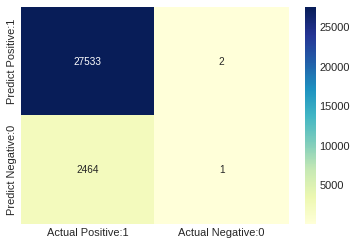

In [ ]:
train_lightGBM()



---



**Train Logistic Regression**

In [ ]:
def train_logistic_regression():
  lr = LogisticRegression()
  lr.fit(X_train, y_train)

  y_pred = lr.predict(X_test)
  print_model_evaluation_matrix(y_test, y_pred)

---------------------------------------------------------------------------------------------------- 

Accuracy: 0.9178333333333333
Confusion matrix: 

 [[27535     0]
 [ 2465     0]]

True Positives(TP) =  27535

True Negatives(TN) =  0

False Positives(FP) =  0

False Negatives(FN) =  2465
---------------------------------------------------------------------------------------------------- 

Classification Report: 

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     27535
           1       0.00      0.00      0.00      2465

    accuracy                           0.92     30000
   macro avg       0.46      0.50      0.48     30000
weighted avg       0.84      0.92      0.88     30000



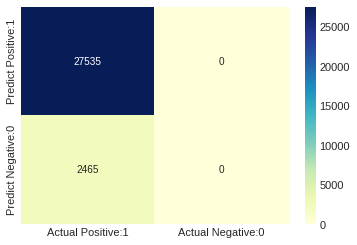

In [ ]:
train_logistic_regression()

# **Neural Network**

> 1st Approach

In [ ]:
# define layers
LAYERS = [tf.keras.layers.Flatten(input_shape=[X_train.shape[1]]),
    tf.keras.layers.Dense(300, kernel_initializer="random_normal", activation='relu'),
    tf.keras.layers.Dense(200, kernel_initializer="random_normal", activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, kernel_initializer="random_normal", activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(50, kernel_initializer="random_normal", activation='relu'),
    tf.keras.layers.Dense(25, kernel_initializer="random_normal", activation='relu'),
    tf.keras.layers.Dense(1, activation="sigmoid")]

# add layers to Sequential model
model = tf.keras.models.Sequential(LAYERS)

In [ ]:
# view model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 19)                0         
                                                                 
 dense (Dense)               (None, 300)               6000      
                                                                 
 dense_1 (Dense)             (None, 200)               60200     
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                        

In [ ]:
# define early stopping callback
# wait for 5 epochs, if result didn't get improved, it will stop to run new training epoch
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)

# total epochs
total_epochs = 30

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = total_epochs, batch_size=32, callbacks=[early_stopping_cb])

Epoch 1/30
2188/2188 [==============================] - 9s 4ms/step - loss: 0.2943 - accuracy: 0.9168 - val_loss: 0.3110 - val_accuracy: 0.9178
Epoch 2/30
2188/2188 [==============================] - 8s 4ms/step - loss: 0.2886 - accuracy: 0.9171 - val_loss: 0.2881 - val_accuracy: 0.9178
Epoch 3/30
2188/2188 [==============================] - 8s 4ms/step - loss: 0.2869 - accuracy: 0.9171 - val_loss: 0.2859 - val_accuracy: 0.9178
Epoch 4/30
2188/2188 [==============================] - 8s 4ms/step - loss: 0.2864 - accuracy: 0.9171 - val_loss: 0.2843 - val_accuracy: 0.9178
Epoch 5/30
2188/2188 [==============================] - 8s 4ms/step - loss: 0.2855 - accuracy: 0.9171 - val_loss: 0.2850 - val_accuracy: 0.9178
Epoch 6/30
2188/2188 [==============================] - 8s 4ms/step - loss: 0.2852 - accuracy: 0.9171 - val_loss: 0.2837 - val_accuracy: 0.9178
Epoch 7/30
2188/2188 [==============================] - 8s 4ms/step - loss: 0.2848 - accuracy: 0.9171 - val_loss: 0.2885 - val_accuracy:

In [ ]:
acc_ann = model.evaluate(X_test, y_test)[1]

print(f'Accuracy of model is {acc_ann}')

938/938 [==============================] - 1s 2ms/step - loss: 0.2813 - accuracy: 0.9178
Accuracy of model is 0.9178333282470703


In [ ]:
# save model to dir
def saveModel_path(model_dir="TRAINED_MODEL"):
    os.makedirs(model_dir, exist_ok=True)
    fileName = time.strftime("Model_%Y_%m_%d_%H_%M_%S_.h5")    
    model_path = os.path.join(model_dir, fileName)
    print(f"your model will be saved at the following location\n{model_path}")
    return model_path

In [ ]:
tf.keras.models.save_model(model, 'hotel_booking_ann')

In [ ]:
# plot Training and Validation Loss
plt.figure(figsize = (12, 6))
train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss'] 
epoch = model_history.epoch
loss = pd.DataFrame({'train_loss' : train_loss, 'val_loss' : val_loss})
px.line(data_frame = loss, x = epoch, y = ['val_loss', 'train_loss'], title = 'Training and Validation Loss',
        template = 'plotly_dark')

<Figure size 864x432 with 0 Axes>

In [ ]:
# Plot Training and Validation Accuracy
plt.figure(figsize = (12, 6))
train_acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy'] 
epoch = model_history.epoch
accuracy = pd.DataFrame({'train_acc' : train_acc, 'val_acc' : val_acc})
px.line(data_frame = accuracy, x = epoch, y = ['val_acc', 'train_acc'], title = 'Training and Validation Accuracy', template = 'plotly_dark')

<Figure size 864x432 with 0 Axes>



---



> 2nd Approach

- Let's do first feature scaling - Standardize features by removing the mean and scaling to unit variance.

In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
def create_model(layers, activation):
    model = Sequential()
    for i, nodes in enumerate(layers):
        if i==0:
            model.add(Dense(nodes,input_dim=X_train.shape[1]))
            model.add(tf.keras.layers.Activation(activation))
        else:
            model.add(Dense(nodes))
            model.add(tf.keras.layers.Activation(activation))
    model.add(Dense(1, activation='sigmoid')) # Note: no activation beyond this point
    
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
    return model
    
model = KerasClassifier(build_fn=create_model, verbose=0)

In [ ]:
layers = [[45, 30, 15]]
# layers = [[20], [40, 20], [45, 30, 15]]
activations = ['relu']
param_grid = dict(layers=layers, activation=activations, batch_size = [256], epochs=[10])
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=10)

In [ ]:
grid_result = grid.fit(X_train, y_train)

In [ ]:
[grid_result.best_score_,grid_result.best_params_]

[0.9170428454875946,
 {'activation': 'relu',
  'batch_size': 256,
  'epochs': 10,
  'layers': [45, 30, 15]}]

In [ ]:
pred_y = grid.predict(X_test)

In [ ]:
y_pred = (pred_y > 0.5)

---------------------------------------------------------------------------------------------------- 

Accuracy: 0.9178333333333333
Confusion matrix: 

 [[27534     1]
 [ 2464     1]]

True Positives(TP) =  27534

True Negatives(TN) =  1

False Positives(FP) =  1

False Negatives(FN) =  2464
---------------------------------------------------------------------------------------------------- 

Classification Report: 

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     27535
           1       0.50      0.00      0.00      2465

    accuracy                           0.92     30000
   macro avg       0.71      0.50      0.48     30000
weighted avg       0.88      0.92      0.88     30000



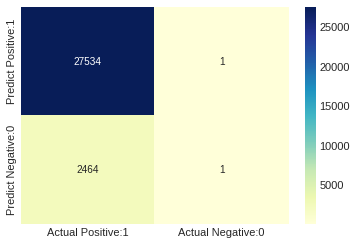

In [ ]:
print_model_evaluation_matrix(y_test, y_pred)

# **Customer Segmentation**

> Let's try to create cluster of users, so based on that we can do recommandation of offers or packages

In [ ]:
# Define K-means model
kmeans_model = KMeans(init='k-means++',  max_iter=400, random_state=42)

In [ ]:
# Train the model
X = df[num_cols]
kmeans_model.fit(X)

KMeans(max_iter=400, random_state=42)

In [ ]:
# Create the K means model for different values of K
def try_different_clusters(K, data):
       
    cluster_values = list(range(1, K+1))
    inertias=[]
    
    for c in cluster_values:
        model = KMeans(n_clusters = c,init='k-means++',max_iter=400,random_state=42)
        model.fit(data)
        inertias.append(model.inertia_)
    
    return inertias

In [ ]:
# Find output for k values between 1 to 12 
outputs = try_different_clusters(12, X)

distances = pd.DataFrame({"clusters": list(range(1, 13)),"sum of squared distances": outputs})

In [ ]:
# sum of squared distances vs cluster num
distances

clusters  sum of squared distances
0          1              1.254806e+15
1          2              3.452609e+14
2          3              1.620974e+14
3          4              1.165159e+14
4          5              8.893113e+13
5          6              7.468573e+13
6          7              6.524116e+13
7          8              5.924453e+13
8          9              5.517986e+13
9         10              5.190780e+13
10        11              4.923489e+13
11        12              4.551679e+13

In [ ]:
# Finding optimal number of clusters k
figure = go.Figure()
figure.add_trace(go.Scatter(x=distances["clusters"], y=distances["sum of squared distances"]))

figure.update_layout(xaxis = dict(tick0 = 1,dtick = 1,tickmode = 'linear'),                  
                  xaxis_title="Number of clusters",
                  yaxis_title="Sum of squared distances",
                  title_text="Finding optimal number of clusters using elbow method")
figure.show()

> We can see that 3 or 4 is the best optimal cluster for this dataset

In [ ]:
# Re-Train K means model with k=3
kmeans_model_new = KMeans(n_clusters = 3, init='k-means++',max_iter=400,random_state=42)

y_kmeans = kmeans_model_new.fit_predict(X)

In [ ]:
# Create data arrays
cluster_centers = kmeans_model_new.cluster_centers_
data = np.expm1(cluster_centers)
points = np.append(data, cluster_centers, axis=1)
points

array([[1.54884236e+004, 1.27608211e+001, 1.19602614e+035,
        2.14531379e+137,             inf,             inf,
                    inf, 1.39462098e-001, 2.83668503e-001,
        3.01108590e+002, 6.65465468e+000, 3.80179007e-001,
        2.08002014e+000,             inf, 1.32084014e+001,
        8.59326630e-002, 3.34775702e+000, 2.61886081e+001,
        7.01720131e+034, 6.07065791e+264, 4.74823931e+021,
        9.64791272e+000, 2.62182550e+000, 8.07694828e+001,
        3.16217444e+002, 2.89473821e+004, 1.86736276e+003,
        7.56748519e+004, 1.30556307e-001, 2.49721997e-001,
        5.71078652e+000, 2.03531392e+000, 3.22213206e-001,
        1.12493613e+000, 1.48244923e+004, 2.65383344e+000,
        8.24392150e-002, 1.46966008e+000, 3.30279806e+000,
        8.02362576e+001, 6.09685932e+002, 4.99120608e+001],
       [1.41008596e+004, 1.23285511e+001, 4.72672166e+036,
        2.07536679e+141,             inf,             inf,
                    inf, 1.54549969e-001, 3.26939963e-0

In [ ]:
# Add "clusters" to dataframe
points = np.append(points, [[0], [1], [2]], axis=1)
df["new_clusters"] = kmeans_model_new.labels_

In [ ]:
df.head()

date_time  site_name  posa_continent  user_location_country  \
0 2014-08-11 07:46:59          2               3                     66   
1 2014-08-11 08:22:12          2               3                     66   
2 2014-08-11 08:24:33          2               3                     66   
3 2014-08-09 18:05:16          2               3                     66   
4 2014-08-09 18:08:18          2               3                     66   

   user_location_region  user_location_city  orig_destination_distance  \
0                   348               48862                  2234.2641   
1                   348               48862                  2234.2641   
2                   348               48862                  2234.2641   
3                   442               35390                   913.1932   
4                   442               35390                   913.6259   

   user_id  is_mobile  is_package  channel    srch_ci    srch_co  \
0       12          0           1        9 2014-08-27 2014-08-31   
1       12          0           1        9 2014-08-29 2014-09-02   
2       12          0           0        9 2014-08-29 2014-09-02   
3       93          0           0        3 2014-11-23 2014-11-28   
4       93          0           0        3 2014-11-23 2014-11-28   

   srch_adults_cnt  srch_children_cnt  srch_rm_cnt  srch_destination_id  \
0                2                  0            1                 8250   
1                2                  0            1                 8250   
2                2                  0            1                 8250   
3                2                  0            1                14984   
4                2                  0            1                14984   

   srch_destination_type_id  is_booking  cnt  hotel_continent  hotel_country  \
0                         1           0    3                2             50   
1                         1           1    1                2             50   
2                         1           0    1                2             50   
3                         1           0    1                2             50   
4                         1           0    1                2             50   

   hotel_market  hotel_cluster  stay_days  days_btw_booking_ci  cin_day  \
0           628              1        4.0                 15.0       27   
1           628              1        4.0                 17.0       29   
2           628              1        4.0                 17.0       29   
3          1457             80        5.0                105.0       23   
4          1457             21        5.0                105.0       23   

   cin_month  cin_year  new_clusters  
0          8      2014             0  
1          8      2014             0  
2          8      2014             0  
3         11      2014             0  
4         11      2014             0

In [ ]:
# visualize clusters
figure = px.scatter_3d(df,
                    color='new_clusters',
                    x="cin_month",
                    y="hotel_continent",
                    z="channel",            
                    category_orders = {"clusters": ["0", "1", "2"]}                    
                    )
figure.update_layout()
figure.show()

In [ ]:
# visualize clusters
figure = px.scatter(df,
                    color='new_clusters',
                    x="orig_destination_distance",
                    y="srch_destination_id",
                    category_orders = {"clusters": ["0", "1", "2"]}                    
                    )
figure.update_layout()
figure.show()



---



**The End**



---

